In [1]:
from cartopy.crs import NorthPolarStereo, LambertAzimuthalEqualArea
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
from scipy.interpolate import RegularGridInterpolator


In [2]:
# Download ice drift and deformation file
!wget -nc --no-check-certificate https://thredds.nersc.no/thredds/fileServer/sios_infranor_icedrift/arctic_2km_deformation_mosaic/2021/12/arctic_2km_deformation_20211201T000000.nc
# Download thickness and concentration file
!wget -nc ftp://ftp.awi.de/sea_ice/product/cryosat2_smos/v205/nh/2021/12/W_XX-ESA,SMOS_CS2,NH_25KM_EASE2_20211201_20211207_r_v205_01_l4sit.nc

--2023-05-25 14:23:49--  https://thredds.nersc.no/thredds/fileServer/sios_infranor_icedrift/arctic_2km_deformation_mosaic/2021/12/arctic_2km_deformation_20211201T000000.nc
Resolving thredds.nersc.no (thredds.nersc.no)... 10.47.30.222
Connecting to thredds.nersc.no (thredds.nersc.no)|10.47.30.222|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 
Length: 5026676 (4.8M) [application/x-netcdf]
Saving to: ‘arctic_2km_deformation_20211201T000000.nc.1’

arctic_2km_deformat 100%[===================>]   4.79M  --.-KB/s    in 0.07s   

2023-05-25 14:23:49 (66.6 MB/s) - ‘arctic_2km_deformation_20211201T000000.nc.1’ saved [5026676/5026676]

--2023-05-25 14:23:49--  ftp://ftp.awi.de/sea_ice/product/cryosat2_smos/v205/nh/2021/12/W_XX-ESA,SMOS_CS2,NH_25KM_EASE2_20211201_20211207_r_v205_01_l4sit.nc
           => ‘W_XX-ESA,SMOS_CS2,NH_25KM_EASE2_20211201_20211207_r_v205_01_l4sit.nc.2’
Resolving ftp.awi.de (ftp.awi.de)... 134.1.2.47
Connec

In [3]:
# Read data from ice drift and deformation file
url = 'arctic_2km_deformation_20211201T000000.nc'
with Dataset(url) as ds:
    x = ds['x'][:]
    y = ds['y'][:]
    e1_med = ds['e1_med'][0]
    e2_med = ds['e2_med'][0]
    mask = ds['mask'][0]

# flip matrices with data as they are incorrect in the NC file
e1_med, e2_med, mask = [i[::-1] for i in [e1_med, e2_med, mask]]

/tmp/ipykernel_1937/3854265312.py:8: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  mask = ds['mask'][0]


In [4]:
# read thickness and concentration
cs2smos_file = 'W_XX-ESA,SMOS_CS2,NH_25KM_EASE2_20211201_20211207_r_v205_01_l4sit.nc'
with Dataset(cs2smos_file) as ds:
    xc = ds['xc'][:]
    yc = ds['yc'][:]
    analysis_sea_ice_thickness = ds['analysis_sea_ice_thickness'][0].filled(0)
    sea_ice_concentration = ds['sea_ice_concentration'][0].filled(0)

# convert X, Y coordinates to meters
xc *= 1000
yc *= 1000


In [5]:
# Define projection of the sea ice drift product
nps = NorthPolarStereo(-45, 70)
# define projection of the thickness product
laea = LambertAzimuthalEqualArea(0, 90)

In [6]:
# create matrices of coordinates for reprojection of SIT product from LAEA to NPS projection
# NPS coordinates on NPS grid
x_grd, y_grd = np.meshgrid(x, y)
# LAEA coordinates on NPS grid
grd_laea = laea.transform_points(nps, x_grd, y_grd)
x_grd_laea, y_grd_laea = grd_laea[:,:,0], grd_laea[:,:,1]

In [13]:
# Prepare interpolators for thickness and concentration
rgi1 = RegularGridInterpolator((yc[::-1], xc), analysis_sea_ice_thickness[::-1], method='nearest')
rgi2 = RegularGridInterpolator((yc[::-1], xc), sea_ice_concentration[::-1], method='nearest')
# Do interpolation from LAEA grid onto NPS grid
sit = rgi1((y_grd_laea, x_grd_laea))[::-1]
sic = rgi2((y_grd_laea, x_grd_laea))[::-1]

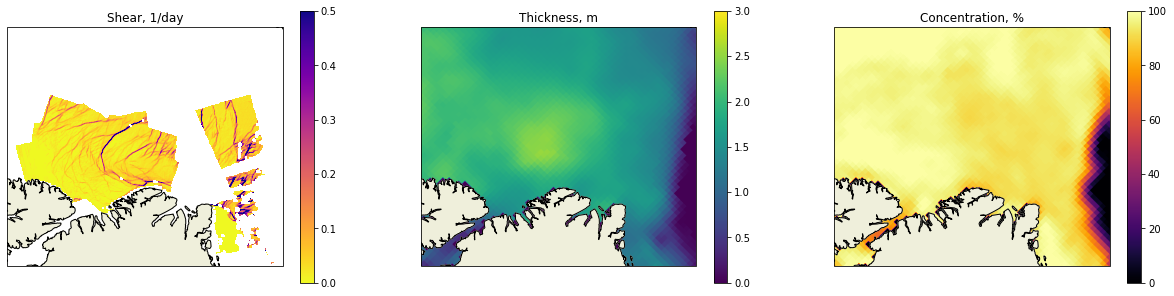

In [15]:
# plot on a map
titles = ['Shear, 1/day', 'Thickness, m', 'Concentration, %']
fig, axs = plt.subplots(1,3,subplot_kw={'projection': nps}, figsize=(21,10))
imsh0 = axs[0].imshow(e2_med, extent=[x[0], x[-1], y[0], y[-1]], clim=[0, 0.5], cmap='plasma_r', zorder=0)
plt.colorbar(imsh0, ax=axs[0], shrink=0.5)
imsh1 = axs[1].imshow(sit, extent=[x[0], x[-1], y[0], y[-1]], clim=[0, 3], cmap='viridis', zorder=0)
plt.colorbar(imsh1, ax=axs[1], shrink=0.5)
imsh2 = axs[2].imshow(sic, extent=[x[0], x[-1], y[0], y[-1]], clim=[0, 100], cmap='inferno', zorder=0)
plt.colorbar(imsh2, ax=axs[2], shrink=0.5)

for iax, ax in enumerate(axs):
    ax.add_feature(cfeature.LAND, zorder=1)
    ax.add_feature(cfeature.COASTLINE, zorder=2)
    ax.set_ylim([y.min(), y.max()])
    ax.set_title(titles[iax])
plt.show()

